In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
#add the parent directory to the path
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
from src.draw import Visualize
import src.utils as utils

In [3]:
#TO csv
parent_directory = '/home/biniyam/tenx-tasks/tenxdata/'
    

df_json = SlackDataLoader.slack_parser_all(parent_directory)

df_json.to_csv('all-weeks.csv', index=False)

#TO dataframe
df = pd.read_csv('all-weeks.csv')

df.head()

/home/biniyam/tenac/tenx-tasks/src/loader.py:256: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'], unit='s')
/home/biniyam/tenac/tenx-tasks/src/loader.py:257: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['time_thread_start'] = pd.to_datetime(df['time_thread_start'], unit='s')
/home/biniyam/tenac/tenx-tasks/src/loader.py:258: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a fu

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,Message,I think <@U03UH397319> has to be a presenter f...,Katie Dickerson,2022-09-05 07:17:20,Text,1970-01-01 00:00:00,0,0,[''],1970-01-01 00:00:00,team-10
1,Message,We will be also there assisting him.,Katie Dickerson,2022-09-05 07:19:28,Text,1970-01-01 00:00:00,0,0,[''],1970-01-01 00:00:00,team-10
2,Message,where are you guys?,Katie Dickerson,2022-08-30 07:00:16,Text,1970-01-01 00:00:00,0,0,[''],1970-01-01 00:00:00,team-10
3,Message,Is the meeting at 8?,Brenda Hernandez,2022-08-30 07:40:48,Text,1970-01-01 00:00:00,0,0,[''],1970-01-01 00:00:00,team-10
4,Message,"I was reading, I was not there. And I thought ...",Brenda Hernandez,2022-08-30 07:40:48,Text,1970-01-01 00:00:00,0,0,[''],1970-01-01 00:00:00,team-10


In [4]:
#convert all non-string values to string
df['msg_content'] = df['msg_content'].astype(str)

# Apply regular expressions after ensuring all values are strings
df['msg_content'] = df['msg_content'].apply(lambda x: re.sub(r'http\S+', '', x))
df['msg_content'] = df['msg_content'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['msg_content'] = df['msg_content'].apply(lambda x: re.sub(r'\d+', '', x))
# assuming 'utils.remove_emoji' works correctly for string inputs
df['msg_content'] = df['msg_content'].apply(utils.remove_emoji)

In [5]:
df['msg_sent_time'] = pd.to_datetime(df['msg_sent_time'])

grouped = df.groupby(df['msg_sent_time'].dt.date)['msg_content'].apply(lambda x: ' '.join(x)).reset_index()

grouped.head()

,msg_sent_time,msg_content
0,2022-08-20,I am glad to make it to the week program I wo...
1,2022-08-21,Hi all looking forward to starting together to...
2,2022-08-22,channel Id like to welcome you all to this cha...
3,2022-08-23,TUTORIAL REMINDER channel\nPlease be aware t...
4,2022-08-24,Good morning sun_with_face channel I hope we a...


In [17]:
from transformers import pipeline

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import torch

In [18]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
text = "Covid cases are increasing fast!"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
def sentiment_score(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    output = model(**encoded_input)
    scores = torch.softmax(output.logits, dim=1).detach().numpy()
    return scores

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
sentiment_scores = []

for text in grouped['msg_content']:
    scores = sentiment_score(text)
    sentiment_scores.append(scores)

grouped['sentiment_scores'] = sentiment_scores

In [22]:
grouped['sentiment_scores'].head(69)

0      [[0.002303484, 0.009526638, 0.9881699]]
1     [[0.0020225581, 0.009004733, 0.9889727]]
2     [[0.0035404258, 0.33491167, 0.66154784]]
3       [[0.019432293, 0.8865346, 0.09403316]]
4       [[0.004821367, 0.11691087, 0.8782678]]
                        ...                   
64      [[0.12376981, 0.69619125, 0.18003893]]
65     [[0.35635525, 0.58135873, 0.062286012]]
66      [[0.028516516, 0.5485028, 0.42298067]]
67        [[0.1331199, 0.7057204, 0.16115966]]
68     [[0.015583751, 0.72513586, 0.25928035]]
Name: sentiment_scores, Length: 69, dtype: object

In [24]:
import ast

grouped['negative'] = grouped['sentiment_scores'].apply(lambda x: x[0][0])
grouped['neutral'] = grouped['sentiment_scores'].apply(lambda x: x[0][1])
grouped['positive'] = grouped['sentiment_scores'].apply(lambda x: x[0][2])

grouped.drop('sentiment_scores', axis=1, inplace=True)
grouped.head()

,msg_sent_time,msg_content,negative,neutral,positive
0,2022-08-20,I am glad to make it to the week program I wo...,0.002303,0.009527,0.988170
1,2022-08-21,Hi all looking forward to starting together to...,0.002023,0.009005,0.988973
2,2022-08-22,channel Id like to welcome you all to this cha...,0.003540,0.334912,0.661548
3,2022-08-23,TUTORIAL REMINDER channel\nPlease be aware t...,0.019432,0.886535,0.094033
4,2022-08-24,Good morning sun_with_face channel I hope we a...,0.004821,0.116911,0.878268


In [32]:
grouped.to_csv('sentiment_scores.csv', index=False)


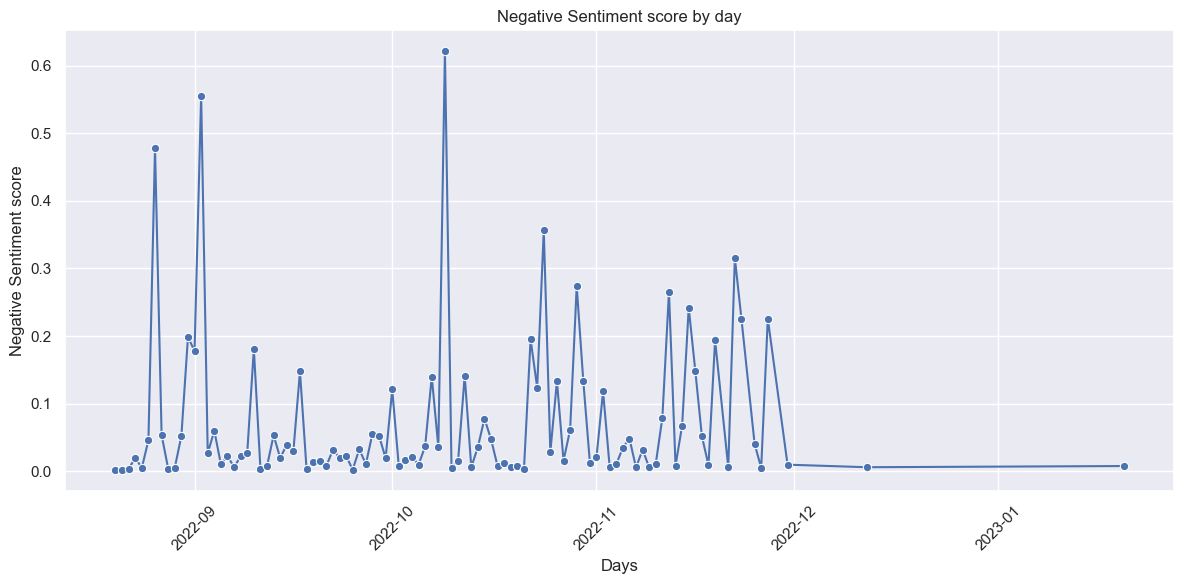

In [29]:
from matplotlib import lines


grouped['msg_sent_time'] = pd.to_datetime(grouped['msg_sent_time'])

plt.figure(figsize=(12,6))
sns.set(style='darkgrid')


sns.lineplot(data=grouped, x=grouped['msg_sent_time'].dt.date, y=grouped['negative'], marker='o')
# plt.plot(grouped['msg_sent_time'].dt.date, grouped['negative'], marker='o', linestyle='-', label='negative')
plt.xlabel('Days')
plt.ylabel('Negative Sentiment score')
plt.title('Negative Sentiment score by day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

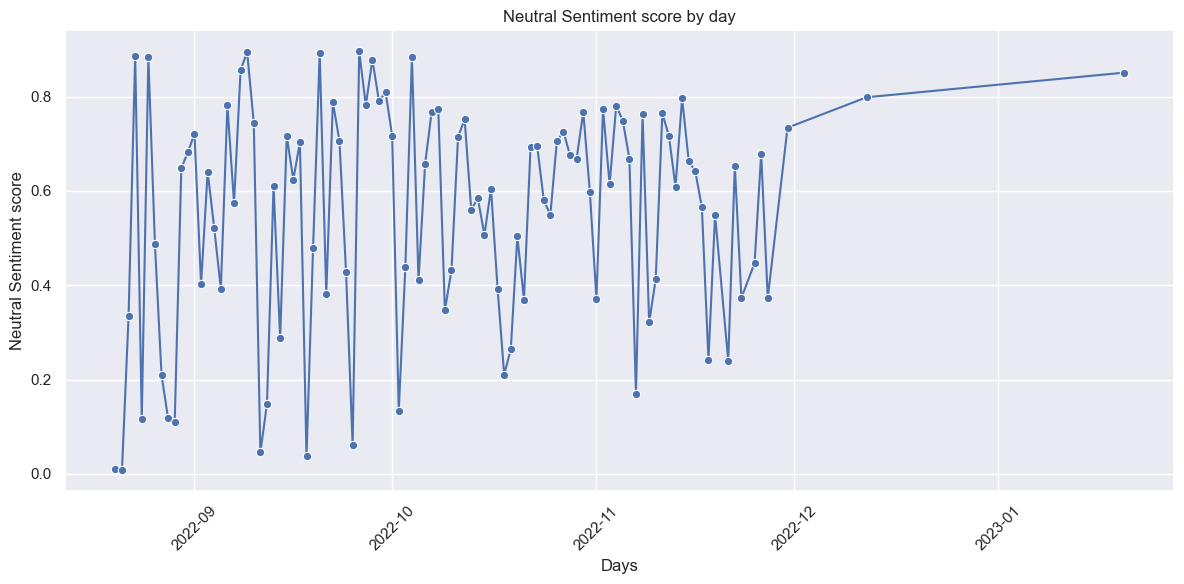

In [30]:
grouped['msg_sent_time'] = pd.to_datetime(grouped['msg_sent_time'])

plt.figure(figsize=(12,6))
sns.set(style='darkgrid')


sns.lineplot(data=grouped, x=grouped['msg_sent_time'].dt.date, y=grouped['neutral'], marker='o')
# plt.plot(grouped['msg_sent_time'].dt.date, grouped['negative'], marker='o', linestyle='-', label='negative')
plt.xlabel('Days')
plt.ylabel('Neutral Sentiment score')
plt.title('Neutral Sentiment score by day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

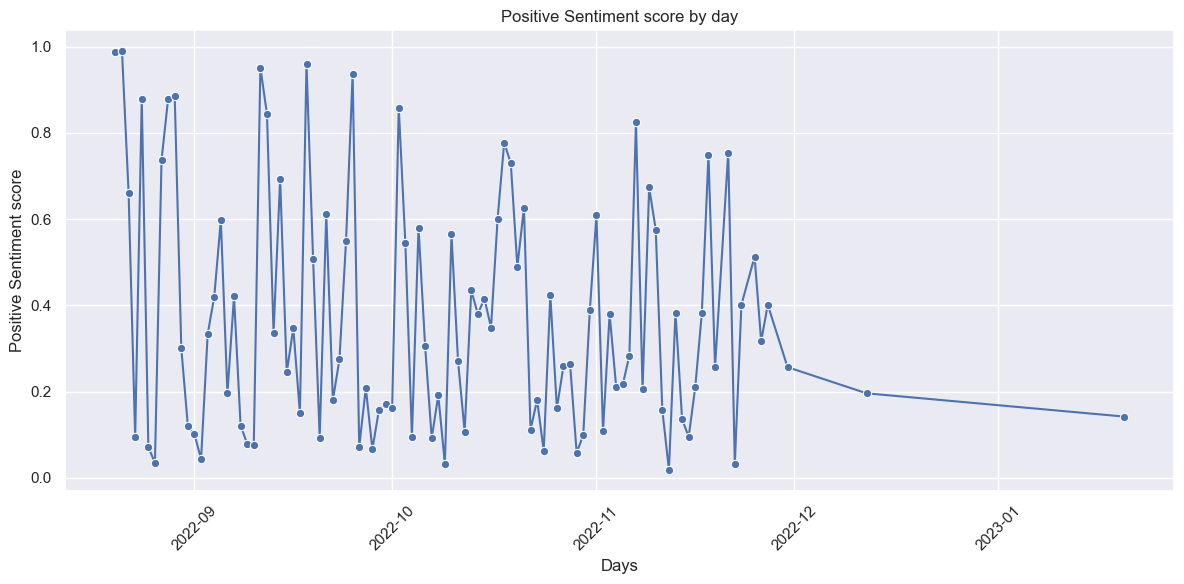

In [31]:
grouped['msg_sent_time'] = pd.to_datetime(grouped['msg_sent_time'])

plt.figure(figsize=(12,6))
sns.set(style='darkgrid')


sns.lineplot(data=grouped, x=grouped['msg_sent_time'].dt.date, y=grouped['positive'], marker='o')
# plt.plot(grouped['msg_sent_time'].dt.date, grouped['negative'], marker='o', linestyle='-', label='negative')
plt.xlabel('Days')
plt.ylabel('Positive Sentiment score')
plt.title('Positive Sentiment score by day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()